In [1]:
import numpy as np
import data
from timeit import default_timer as timer

In [2]:
ml_100k = data.ml_100k
train = data.train
test = data.test

In [3]:
class MatrixFactorization():
    
    def __init__(self, data, train, test, f, epsilon):
        """
        param train : Rating Matrix for train
        param test : Rating Matrix for test
        param f : latent feature parameter
        """
        
        self._A_I = np.array(np.vectorize(lambda x: 0 if x==0 else 1)(data), dtype = np.float64)
        self._R = train # Implication Matrix for training size (m, n)
        self._R_test = test # Implication Matrix for test size (m, n)
        self._P = np.array(np.vectorize(lambda x: 0 if x==0 else 1)(train), dtype = np.float64) # Preference Matrix for training
        self._P_test = np.array(np.vectorize(lambda x: 0 if x==0 else 1)(test), dtype = np.float64) # Preference Matrix for training
        self._n_user_rated = np.sum(self._P, axis = 1)
        self._n_item_rated = np.sum(self._P, axis = 0)
        self._num_users, self._num_items = train.shape
        self._alpha = 1
        self._lambda = 0.01
        self._C = 1 + self._alpha * self._R # Confidence Matrix size (m, n)
        self._f = f
        self._epsilon = epsilon
        
        
    def fit(self):
        """
        training Matrix Factorization : update matrix latent weight and bias
        """
        # init latent features
        self._X = np.random.normal(0, 0.1, size=(self._num_users, self._f))
        self._Y = np.random.normal(0, 0.1, size=(self._num_items, self._f))
        
        count = 0
        cost_diff = 1000000
        self._training_process = []
        self._cost = [0]
        time = 0
        # repeat ALS until convergence
        for i in range(20) :
            
            start_opt = timer()
            count += 1
            self._yTy = self._Y.T.dot(self._Y)
            for u in range(self._num_users):
                self.optimize_x(u)
            
            self._xTx = self._X.T.dot(self._X)
            for i in range(self._num_items):
                self.optimize_y(i)
            
            print("time for optimization: %.4f" % (timer()-start_opt))
            
            cost = self.cost()
            self._cost.append(cost)
            if count > 1 :
                cost_diff = self._cost[count - 1] - self._cost[count]
            # rank = self.compute_rank()
            start_AUC = timer()
            AUC = self.compute_AUC()
            print("AUC : %.4f, time for compute AUC : %.4f" % (AUC, (timer() - start_AUC)))
            self._training_process.append([count, cost_diff, AUC])

                
                
    def optimize_x(self, u):
        """
        Optimize X given user u
        """
        C_u = np.diag(self._C[u, :]) # create diagonal matrix size (n, n)
        
        # (f,f) matrix
        temp1 = self._yTy + self._Y.T.dot(C_u - np.identity(self._num_items)).dot(self._Y) + self._lambda * np.identity(self._f)
        # (f,1) matrix
        temp2 = self._Y.T.dot(C_u).dot(self._P[u])
        
        self._X[u, :] = np.linalg.inv(temp1).dot(temp2)
        
    
    def optimize_y(self, i):
        """
        Optimize X given user u
        """
        C_i = np.diag(self._C[:, i]) # create diagonal matrix size (m, m)
        
        # (f,f) matrix
        temp1 = self._xTx + self._X.T.dot(C_i - np.identity(self._num_users)).dot(self._X) + self._lambda * np.identity(self._f)
        # (f,1) matrix
        temp2 = self._X.T.dot(C_i).dot(self._P[:, i])
        
        self._Y[i, :] = np.linalg.inv(temp1).dot(temp2)
        
                
    def cost(self):
        """
        compute Loss function
        """
        loss = np.sum(self._C * np.square(self._P - self._X.dot(self._Y.T))) + self._lambda * (np.linalg.norm(self._X) + np.linalg.norm(self._Y))
        
        return loss
    
    
    def compute_AUC(self):
        
        self._P_hat = self._X.dot(self._Y.T)
        u_nonzero, i_nonzero = self._P_test.nonzero()
        num = 0
        
        for u in u_nonzero :
            temp = 0
            temp_i = self._P_test[u].nonzero()[0]
            temp_j = np.argwhere(self._A_I[u] == 0).T[0]
            for i in temp_i :
                for j in temp_j :
                    if self._P_hat[u, i] > self._P_hat[u, j] :
                        temp += 1
            num += (temp / (len(temp_i)*len(temp_j)))
        auc = num / len(u_nonzero)
        
        return auc
    
    
    def print_results(self):
        """
        print fit results
        """

        print("Final P hat matrix:")
        print(self._X.dot(self._Y.T))

In [4]:
np.random.seed(7)
    
np.seterr(all="warn")
    
factorizer = MatrixFactorization(ml_100k, train, test, f=40, epsilon = 1.0)
factorizer.fit()

time for optimization: 33.8660
AUC : 0.7892, time for compute AUC : 1386.8522
time for optimization: 33.0932
AUC : 0.8626, time for compute AUC : 1396.9550
time for optimization: 33.3945
AUC : 0.8667, time for compute AUC : 1402.1731
time for optimization: 33.0041
AUC : 0.8679, time for compute AUC : 1400.8226
time for optimization: 32.9354
AUC : 0.8687, time for compute AUC : 1408.2139
time for optimization: 33.3036
AUC : 0.8693, time for compute AUC : 1347.6375
time for optimization: 32.9537
AUC : 0.8697, time for compute AUC : 1390.1367
time for optimization: 33.3141
AUC : 0.8700, time for compute AUC : 1348.5766
time for optimization: 32.7303
AUC : 0.8702, time for compute AUC : 1401.6796
time for optimization: 32.9182
AUC : 0.8703, time for compute AUC : 1420.1968
time for optimization: 33.0390
AUC : 0.8703, time for compute AUC : 1402.2190
time for optimization: 32.8391
AUC : 0.8703, time for compute AUC : 1392.1697
time for optimization: 32.8942
AUC : 0.8703, time for compute AU

In [5]:
ind_list = []
drop_list = []
AUC_list = []

for i in range(1, len(factorizer._training_process)):
    ind_list.append(factorizer._training_process[i][0])
    drop_list.append(factorizer._training_process[i][1])
    AUC_list.append(factorizer._training_process[i][2])

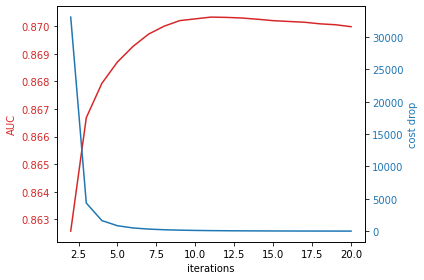

In [8]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('iterations')
ax1.set_ylabel('AUC', color=color)
ax1.plot(ind_list, AUC_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cost drop', color=color)  # we already handled the x-label with ax1
ax2.plot(ind_list, drop_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()